# <b><u>False Positive Analysis and Cleaning<b><u>

This script offers a cleaning approach for falsly predicted crop pixels using a Random Forest Model which is trained on labeled training data.

### Load necessary packages

In [1]:
# Standard library imports
import math
import os
import random
import shutil
import tempfile
from collections import defaultdict
from math import ceil

# Third-party imports
import ee
import geemap
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from osgeo import gdal, gdalconst, osr
from rasterio.windows import Window
from scipy.stats import randint, uniform
from shapely.geometry import Point
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from tqdm import tqdm
import joblib

# **Section 1: Reclassify Rasters and create Sampling Points**

#### Step 1: Reclassify Predicted Fractional Map to low frequency and high frequency crop field 

In [ ]:
# Input merged Raster
input_path = r"C:\Users\phili\Thesis\tmp\ValidatedTiles\merged_fractional_map.tif"

In [ ]:
output_dir = r"C:\Users\phili\Thesis\tmp\false_positive_analysis\FP_Raster_output"
os.makedirs(output_dir, exist_ok=True)  # Create directory if missing
output_path = os.path.join(output_dir, "crop_frequency_reclass.tif")

In [ ]:
# Open input raster
src_ds = gdal.Open(input_path)
band = src_ds.GetRasterBand(1)
xsize = band.XSize
ysize = band.YSize

# Create output raster with same dimensions and projection
driver = gdal.GetDriverByName('GTiff')
dst_ds = driver.Create(
    output_path, xsize, ysize, 1, gdal.GDT_Byte,
    options=['COMPRESS=LZW', 'BIGTIFF=YES']
)
dst_ds.SetProjection(src_ds.GetProjection())
dst_ds.SetGeoTransform(src_ds.GetGeoTransform())
out_band = dst_ds.GetRasterBand(1)
out_band.SetNoDataValue(0)

# Optimize block size based on raster structure
block_sizes = band.GetBlockSize()
x_block_size = block_sizes[0]
y_block_size = block_sizes[1]

# Process raster in blocks
for y in range(0, ysize, y_block_size):
    if y + y_block_size < ysize:
        rows = y_block_size
    else:
        rows = ysize - y
        
    for x in range(0, xsize, x_block_size):
        if x + x_block_size < xsize:
            cols = x_block_size
        else:
            cols = xsize - x

        # Read block
        data = band.ReadAsArray(x, y, cols, rows)
        
        # Reclassify using vectorized operations
        reclassified = np.full(data.shape, 0, dtype=np.uint8)  # Initialize with NoData
        mask_low = (data > 0) & (data <= 50)
        mask_high = data > 50
        reclassified[mask_low] = 1
        reclassified[mask_high] = 2
        
        # Write block
        out_band.WriteArray(reclassified, x, y)

# Finalize output
dst_ds.FlushCache()
dst_ds = None
src_ds = None

### Step 2: Reclassify Land Cover Crop Raster to 3 classes: 0 (all agree non-crop), 1 (1-2 agree it's crop), 2 (3-4 agree it's crop)

In [ ]:
input_path = r"C:\Users\phili\Thesis\tmp\no_crop_mask\non_crop_mask_final.tif"
output_dir = r"C:\Users\phili\Thesis\tmp\false_positive_analysis\FP_Raster_output"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "landcover_crop_reclass.tif")

In [ ]:

with rasterio.open(input_path) as src:
    profile = src.profile.copy()
    profile.update(
        dtype='uint8',
        nodata=255,
        compress='lzw'
    )
    
    with rasterio.open(output_path, 'w', **profile) as dst:
        # Process raster in 512x512 blocks
        for ji, window in src.block_windows(1):
            data = src.read(1, window=window)
            
            # Initialize output with NoData (255)
            reclassified = np.full_like(data, 255, dtype='uint8')
            
            # Exact value reclassification
            reclassified[data == 100] = 0    # Class 0
            reclassified[data == 75] = 1     # Class 1
            reclassified[data == 50] = 1     # Class 1
            reclassified[data == 25] = 2     # Class 2
            reclassified[data == 0] = 2      # Class 2
            
            dst.write(reclassified, window=window, indexes=1)

### Step 3: Intersect both Maps

In [ ]:
# Input paths
crop_freq_path = "/home/airg/PSteinhilber/projects/angola/prediction/FP_Analysis_Raster/crop_frequency_reclass.tif"
lc_path = "/home/airg/PSteinhilber/projects/angola/prediction/FP_Analysis_Raster/landcover_crop_reclass.tif"
output_path = "/home/airg/PSteinhilber/projects/angola/prediction/FP_Analysis_Raster/intersect_fractional_lc.tif"

In [ ]:
# Configure GDAL for massive datasets
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN', 'YES')
gdal.SetConfigOption('CHECK_DISK_FREE_SPACE', 'NO')
gdal.SetConfigOption('GDAL_NUM_THREADS', 'ALL_CPUS')

# Open datasets
crop_ds = gdal.OpenEx(crop_freq_path, gdalconst.GA_ReadOnly)
lc_ds = gdal.OpenEx(lc_path, gdalconst.GA_ReadOnly)

# Get crop raster parameters
crop_gt = crop_ds.GetGeoTransform()
crop_proj = crop_ds.GetProjection()
cols = crop_ds.RasterXSize
rows = crop_ds.RasterYSize

# Create output with compression
driver = gdal.GetDriverByName('GTiff')
output_ds = driver.Create(
    output_path, cols, rows, 1, gdalconst.GDT_Byte,
    options=['COMPRESS=LZW', 'PREDICTOR=2', 'TILED=YES', 'BIGTIFF=YES', 'BLOCKXSIZE=256', 'BLOCKYSIZE=256']
)
output_ds.SetGeoTransform(crop_gt)
output_ds.SetProjection(crop_proj)
output_band = output_ds.GetRasterBand(1)
output_band.SetNoDataValue(0)

# Process in blocks with exact dimension matching
block_size = 1024  # Keep this as-is
total_blocks = ((rows + block_size - 1) // block_size) * ((cols + block_size - 1) // block_size)

with tqdm(total=total_blocks, desc="Processing", unit="block") as pbar:
    for y_offset in range(0, rows, block_size):
        y_height = min(block_size, rows - y_offset)
        
        for x_offset in range(0, cols, block_size):
            x_width = min(block_size, cols - x_offset)
            
            # Read crop frequency block
            crop_block = crop_ds.GetRasterBand(1).ReadAsArray(x_offset, y_offset, x_width, y_height)
            
            # Calculate exact bounds for this block
            x_min = crop_gt[0] + x_offset * crop_gt[1]
            y_max = crop_gt[3] + y_offset * crop_gt[5]
            x_max = x_min + x_width * crop_gt[1]
            y_min = y_max + y_height * crop_gt[5]
            
            # Warp LC data with EXPLICIT output dimensions
            lc_block = gdal.Warp('', lc_path,
                format='MEM',
                outputBounds=(x_min, y_min, x_max, y_max),
                xRes=crop_gt[1],
                yRes=abs(crop_gt[5]),
                width=x_width,  # Force exact dimension match
                height=y_height,
                resampleAlg=gdalconst.GRA_NearestNeighbour,
                outputType=gdalconst.GDT_Byte
            ).ReadAsArray()
            
            # Verify block shapes match
            if crop_block.shape != lc_block.shape:
                raise ValueError(f"Block shape mismatch at ({x_offset},{y_offset}): {crop_block.shape} vs {lc_block.shape}")
            
            # Calculate output classes
            output_data = np.zeros_like(crop_block, dtype=np.uint8)
            
            # Class mapping with explicit casting
            output_data = output_data.astype(np.uint8)
            output_data[(crop_block == 1) & (lc_block == 0)] = 1
            output_data[(crop_block == 1) & (lc_block == 1)] = 2
            output_data[(crop_block == 1) & (lc_block == 2)] = 3
            output_data[(crop_block == 2) & (lc_block == 0)] = 4
            output_data[(crop_block == 2) & (lc_block == 1)] = 5
            output_data[(crop_block == 2) & (lc_block == 2)] = 6
            
            # Write output with exact window
            output_band.WriteArray(output_data, xoff=x_offset, yoff=y_offset)
            pbar.update(1)

# Cleanup
output_ds = None
crop_ds = None
lc_ds = None

print(f"✅ Success! Output created at: {output_path}")


### Step 4: Sample Points within each class

#### 4.1: Count Pixels per Class

In [ ]:
raster_path = "/home/airg/PSteinhilber/projects/angola/prediction/FP_Analysis_Raster/intersect_fractional_lc.tif"
output_path = "/home/airg/PSteinhilber/projects/angola/prediction/FP_Analysis_Raster/sampling_points.gpkg"

In [ ]:
def count_classes_blocked(raster_path):
    """Count pixels per class with progress tracking"""
    ds = gdal.Open(raster_path, gdal.GA_ReadOnly)
    band = ds.GetRasterBand(1)
    nodata = band.GetNoDataValue()
    xsize, ysize = band.XSize, band.YSize
    block_x, block_y = band.GetBlockSize()
    
    counts = {}
    total_blocks = ((ysize + block_y - 1) // block_y) * ((xsize + block_x - 1) // block_x)
    
    with tqdm(total=total_blocks, desc="Counting classes", unit="block") as pbar:
        for y in range(0, ysize, block_y):
            y_height = min(block_y, ysize - y)
            for x in range(0, xsize, block_x):
                x_width = min(block_x, xsize - x)
                data = band.ReadAsArray(x, y, x_width, y_height)
                
                if nodata is not None:
                    data = data[data != nodata]
                
                unique, counts_chunk = np.unique(data, return_counts=True)
                for val, cnt in zip(unique, counts_chunk):
                    if val == 0:  # Skip NoData
                        continue
                    counts[val] = counts.get(val, 0) + int(cnt)
                
                pbar.update(1)
    
    ds = None
    return counts

In [ ]:
# Count classes
class_counts = count_classes_blocked(intersect_raster)
print("Pixel counts per class:", class_counts)

In [ ]:
# Use pre-calculated pixel counts
pixel_counts = {3: 431784025, 1: 15857486835, 4: 6093596578, 
                5: 3622280348, 2: 3342416411, 6: 1171686069}
total_pixels = sum(pixel_counts.values())

# Calculate proportional samples without iterating the raster
samples_per_class = {
    cls: max(1, ceil((count / total_pixels) * 300)) 
    for cls, count in pixel_counts.items()
}


In [ ]:
def calculate_samples(pixel_counts, total_samples=300):
    total = sum(pixel_counts.values())
    samples = {
        cls: max(1, int(round((count / total) * total_samples)))
        for cls, count in pixel_counts.items()
    }
    # Adjust to exact total
    current_total = sum(samples.values())
    if current_total != total_samples:
        adjust_cls = max(samples, key=lambda k: samples[k])
        samples[adjust_cls] += (total_samples - current_total)
    return samples

def random_pixel_sampling(raster_path, samples_per_class, max_attempts=1000000, min_distance_deg=0.001):
    with rasterio.open(raster_path) as src:
        height, width = src.height, src.width
        classes_needed = samples_per_class.copy()
        found_points = defaultdict(list)
        found_coords = []

        total_needed = sum(classes_needed.values())
        attempts = 0

        # For progress bar
        pbar = tqdm(total=total_needed, desc="Random sampling", unit="pt")

        while sum(classes_needed.values()) > 0 and attempts < max_attempts:
            # Random pixel
            row = random.randint(0, height - 1)
            col = random.randint(0, width - 1)
            val = src.read(1, window=rasterio.windows.Window(col, row, 1, 1))[0, 0]

            # Only sample if this class still needs points
            if val in classes_needed and classes_needed[val] > 0:
                # Convert to lon/lat
                lon, lat = src.xy(row, col)
                pt = Point(lon, lat)

                # Check minimum distance constraint
                too_close = False
                for other_pt in found_coords:
                    if pt.distance(other_pt) < min_distance_deg:
                        too_close = True
                        break
                if too_close:
                    attempts += 1
                    continue

                found_points[val].append(pt)
                found_coords.append(pt)
                classes_needed[val] -= 1
                pbar.update(1)
            attempts += 1

        pbar.close()

        # Flatten to GeoDataFrame
        data = []
        for cls, pts in found_points.items():
            for pt in pts:
                data.append({'class': cls, 'geometry': pt})
        gdf = gpd.GeoDataFrame(data, crs='EPSG:4326')

        if sum(classes_needed.values()) > 0:
            print(f"Warning: Could not find all samples. Missing: {classes_needed}")

        return gdf



In [ ]:

def main():
    samples = calculate_samples(pixel_counts)
    print("Samples per class:", samples)
    gdf = random_pixel_sampling(raster_path, samples, min_distance_deg=0.001)  # ~100m at equator
    gdf.to_file(output_path, driver="GPKG")
    print(f"Saved {len(gdf)} points to {output_path}")

if __name__ == "__main__":
    main()

<br>

---

<br>

# **Section 2: Sampling in Google Earth Engine**

### Connect to GEE

In [114]:
ee.Authenticate()
# Initialize the Earth Engine API and Project
ee.Initialize(project='angola-thesis')

In [115]:
# Load sampling points 
points = ee.FeatureCollection('projects/angola-thesis/assets/sampling_points_labeled')

# Load Angola boundary 
angola = ee.FeatureCollection('projects/angola-thesis/assets/angola_tiles_dissolve')

# Check if assets exist
print(points.size().getInfo())  # Should return 300
print(angola.size().getInfo())  # Should return 1 


300
1


## Load Predictor Variables

#### DEM

In [4]:
# ALOS DSM (12m)
alos = ee.ImageCollection('JAXA/ALOS/AW3D30/V3_2') \
         .mosaic() \
         .select('DSM') \
         .clip(angola)

# Terrain derivatives
slope = ee.Terrain.slope(alos).rename('slope')
tpi = alos.subtract(alos.reduceNeighborhood(
    reducer=ee.Reducer.mean(),
    kernel=ee.Kernel.square(3)
)).rename('tpi')


#### Soil Texture

In [5]:
# Soil Texture (250m)
soil = ee.Image('OpenLandMap/SOL/SOL_TEXTURE-CLASS_USDA-TT_M/v02') \
    .select('b0').rename('soil_texture')

# ESA WorldCover (10m)
landcover = ee.ImageCollection('ESA/WorldCover/v200') \
    .filterDate('2020-01-01', '2024-12-31') \
    .first()


#### Evapotranspiration + Precipitation

In [6]:
# MODIS Evapotranspiration (500m)
et = ee.ImageCollection('MODIS/061/MOD16A2') \
    .filterDate('2018-01-01', '2023-12-31') \
    .select('ET') \
    .mean() \
    .multiply(0.1)  # Scale factor
# Ends 2023

# CHIRPS Precipitation (5km)
precip = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
    .filterDate('2018-01-01', '2024-12-31') \
    .sum()

# Compute Aridity Index (Precipitation/ET)
aridity = precip.divide(et).rename('aridity')


#### MODIS Temporal Vegetation Features

In [7]:
# MODIS Temporal Features (Phenology)
modis_temp = ee.ImageCollection("MODIS/061/MCD12Q2") \
    .filterDate('2018-01-01', '2023-12-31') \
    .select(['Greenup_1', 'Peak_1', 'QA_Overall_1']) \
    .map(lambda img: img.updateMask(img.select('QA_Overall_1').eq(0))) \
    .mean() \
    .resample('bilinear').reproject(crs='EPSG:4326', scale=500)

In [8]:
def create_modis_ndvi():
    modis = ee.ImageCollection('MODIS/061/MOD13Q1') \
        .filterBounds(angola) \
        .filterDate('2018-01-01', '2024-12-31') \
        .select('NDVI')
    ndvi_mean = modis.mean().multiply(0.0001).rename('modis_ndvi_mean')
    ndvi_std = modis.reduce(ee.Reducer.stdDev()).multiply(0.0001).rename('modis_ndvi_std')
    return ndvi_mean.addBands(ndvi_std)
modis_ndvi = create_modis_ndvi()

#### S2 NDVI

In [9]:
def create_lightweight_ndvi():
    s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
        .filterBounds(angola) \
        .filterDate('2024-01-01', '2024-12-31') \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    ndvi = s2.map(lambda img: img.normalizedDifference(['B8', 'B4']).rename('ndvi')).median().rename('ndvi_2024')
    return ndvi

annual_ndvi_2024 = create_lightweight_ndvi()


In [10]:
def create_seasonal_ndvi():
    s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
        .filterBounds(angola) \
        .filterDate('2024-04-01', '2024-09-30') \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    ndvi = s2.map(lambda img: img.normalizedDifference(['B8', 'B4']).rename('ndvi')).median().rename('ndvi_2024_season')
    return ndvi

seasonal_ndvi_2024 = create_seasonal_ndvi()


In [11]:
# Combine into single NDVI image
ndvi_features = annual_ndvi_2024 \
    .addBands(seasonal_ndvi_2024) \
    .addBands(modis_ndvi)

### Stack all Layers

In [133]:
# --- Helper functions ---
def prep_continuous(img):
    return img.resample('bilinear').reproject(crs='EPSG:32733', scale=10)

def prep_categorical(img):
    return img.reproject(crs='EPSG:32733', scale=10)  # Nearest neighbor by default

# --- Prepare high-res (10m) bands ---
ndvi_2024 = prep_continuous(ndvi_features.select('ndvi_2024'))
ndvi_2024_season = prep_continuous(ndvi_features.select('ndvi_2024_season'))
elevation = prep_continuous(alos.rename('elevation'))
slope_r = prep_continuous(slope)
tpi_r = prep_continuous(tpi)
landcover_r = prep_categorical(landcover.rename('landcover'))


# --- Prepare med-res (250m, upsample to 10m) ---
modis_ndvi_mean = prep_continuous(ndvi_features.select('modis_ndvi_mean'))
modis_ndvi_std = prep_continuous(ndvi_features.select('modis_ndvi_std'))
soil_texture_r = prep_categorical(soil.rename('soil_texture'))
et_r = prep_continuous(et)
aridity_r = prep_continuous(aridity)

# --- Prepare low-res (5km, upsample to 10m) ---
precip_r = prep_continuous(precip.rename('precip'))

# --- Stack all bands together ---
full_stack_10m = ndvi_2024 \
    .addBands(ndvi_2024_season) \
    .addBands(elevation) \
    .addBands(slope_r) \
    .addBands(tpi_r) \
    .addBands(landcover_r) \
    .addBands(modis_ndvi_mean) \
    .addBands(modis_ndvi_std) \
    .addBands(soil_texture_r) \
    .addBands(et_r) \
    .addBands(aridity_r) \
    .addBands(precip_r)

# --- Verify all bands are at 10m ---
band_names = full_stack_10m.bandNames().getInfo()
print('Bands in full_stack_10m:', band_names)
for band in band_names:
    scale = full_stack_10m.select(band).projection().nominalScale().getInfo()
    print(f'{band}: {scale} meters')


Bands in full_stack_10m: ['ndvi_2024', 'ndvi_2024_season', 'elevation', 'slope', 'tpi', 'landcover', 'modis_ndvi_mean', 'modis_ndvi_std', 'soil_texture', 'ET', 'aridity', 'precip']
ndvi_2024: 10 meters
ndvi_2024_season: 10 meters
elevation: 10 meters
slope: 10 meters
tpi: 10 meters
landcover: 10 meters
modis_ndvi_mean: 10 meters
modis_ndvi_std: 10 meters
soil_texture: 10 meters
ET: 10 meters
aridity: 10 meters
precip: 10 meters


### Extract values based on sampling points

In [81]:
def optimized_extraction(points):
    # Extract ALL bands at 10m resolution in one step
    extracted_data = full_stack_10m.select([
        'ndvi_2024', 'ndvi_2024_season',
        'elevation', 'slope', 'tpi', 'landcover',
        'modis_ndvi_mean', 'modis_ndvi_std',
        'soil_texture', 'ET', 'aridity', 'precip'
    ]).reduceRegions(
        collection=points,
        reducer=ee.Reducer.first(),
        scale=10  # Single scale for all bands
    )
    return extracted_data

# Usage remains the same
training_data = optimized_extraction(points)


In [82]:
# Export & Clean DataFrame
df = geemap.ee_to_df(training_data).dropna()

# Remove system columns
df = df[df.columns[~df.columns.str.startswith('system:')]]

# Verify columns
print(df.columns.tolist())

['ET', 'aridity', 'class', 'elevation', 'fid', 'field', 'landcover', 'modis_ndvi_mean', 'modis_ndvi_std', 'ndvi_2024', 'ndvi_2024_season', 'precip', 'slope', 'soil_texture', 'tpi']


In [83]:
print(len(df))


294


In [84]:
df.head()

,ET,aridity,class,elevation,fid,field,landcover,modis_ndvi_mean,modis_ndvi_std,ndvi_2024,ndvi_2024_season,precip,slope,soil_texture,tpi
0,15.819245,431.470581,1,1596,1,0,30,0.580881,0.101225,0.360424,0.355689,6789.705566,0.087670,9,397.789612
1,18.950357,461.125519,1,1128,2,0,30,0.612091,0.091663,0.562645,0.559514,8677.147461,0.046646,6,-38.275917
2,13.188731,199.603119,1,137,3,0,20,0.432457,0.120278,0.313387,0.311231,2631.131592,0.385973,6,-747.220032
3,13.192242,522.936401,1,1448,4,0,20,0.506669,0.110442,0.349949,0.352899,6891.132324,0.161254,9,398.354736
4,17.825676,342.983917,1,1370,6,0,30,0.622564,0.086424,0.566559,0.554272,6114.166016,0.033309,9,131.096237


### Build the RF Model in Python

In [85]:
# X: all predictor columns (drop identifiers and label)
x = df.drop(['fid', 'field', 'ndvi_2024_season', 'soil_texture', 'ndvi_2024', 'modis_ndvi_std', 'modis_ndvi_mean' ], axis=1)

# y: label (1 = field, 0 = non-field)
y = df['field']

In [86]:
# Impute missing values with column medians
imputer = SimpleImputer(strategy='median')
x = pd.DataFrame(imputer.fit_transform(x), columns=x.columns)

In [87]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, 
    test_size=0.3,       # 30% for testing
    stratify=y,          # preserve class balance
    random_state=42
)


In [106]:
rf = RandomForestClassifier(
    n_estimators=256,        # Number of trees
    max_depth=29,            # Limit tree depth to prevent overfitting
    class_weight='balanced', # Handle class imbalance
    random_state=42,
    max_features='log2',
    min_samples_split=10,
)
rf.fit(x_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=29,
                       max_features='log2', min_samples_split=10,
                       n_estimators=256, random_state=42)

Accuracy: 0.87
              precision    recall  f1-score   support

   Non-field       0.91      0.88      0.90        60
       Field       0.77      0.83      0.80        29

    accuracy                           0.87        89
   macro avg       0.84      0.86      0.85        89
weighted avg       0.87      0.87      0.87        89



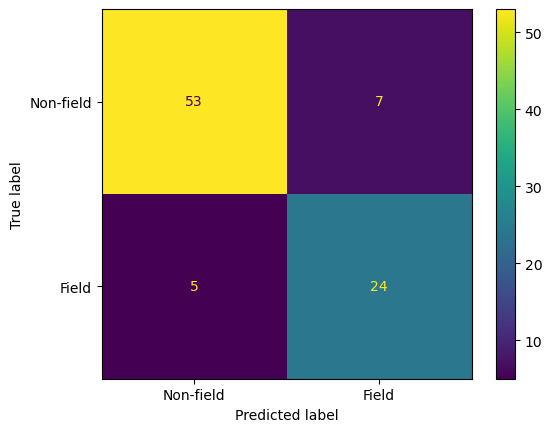

In [107]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = rf.predict(x_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred, target_names=['Non-field', 'Field']))

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Non-field', 'Field']).plot()


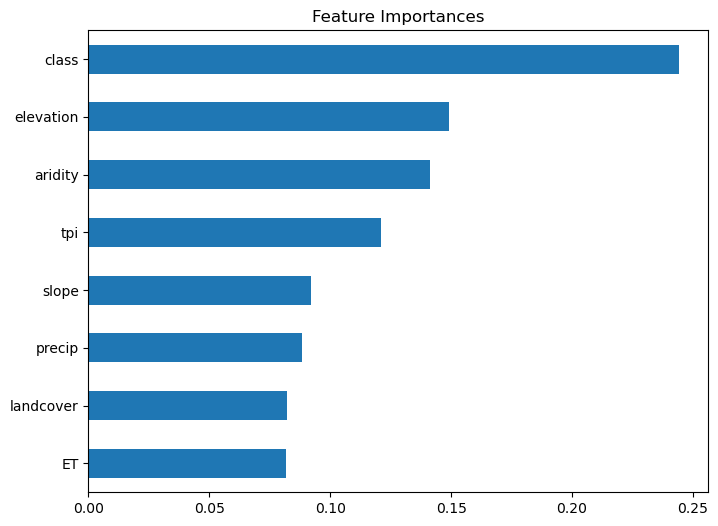

In [108]:
importances = pd.Series(rf.feature_importances_, index=x.columns)
importances.sort_values().plot(kind='barh', figsize=(8,6), title='Feature Importances')
plt.show()


In [109]:
#Save RF Model
joblib.dump(rf, './RF_Model/field_detection_rf_model_04.joblib')  # Saves: model + metadat

['./RF_Model/field_detection_rf_model_04.joblib']

#### Hyperparameter Tuning

In [103]:
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(5, 30),
    'min_samples_split': randint(2, 20),
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced', 'balanced_subsample']
}

rand_search = RandomizedSearchCV(
    RandomForestClassifier(n_jobs=-1, random_state=42),
    param_distributions=param_dist,
    n_iter=50,  # Increased from 10
    cv=5,
    scoring='roc_auc',
    random_state=42
)
rand_search.fit(x_train, y_train)

print('Best hyperparameters:', rand_search.best_params_)
best_rf = rand_search.best_estimator_

Best hyperparameters: {'class_weight': 'balanced_subsample', 'max_depth': 29, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 256}


<br>

---

<br>

# **Section 3: Extract Predictors for Entire Study Area based on Tiles**

### Load Tiles in GEE

In [39]:
# Load Angola Tiles
tiles = ee.FeatureCollection('projects/angola-thesis/assets/angola_tiles_non_overlap_crop_filtered')

# Check if assets exist
print(tiles.size().getInfo()) 

36496


### Add 'Class' Attribute from Sampling Points to Prediction Stack

In [134]:
# Load your class raster
class_raster = ee.Image('projects/angola-thesis/assets/intersect_fractional_lc').rename('class')

# Add to your stack (as the last band, or in the correct order as used in training)
full_stack_10m = full_stack_10m.addBands(class_raster)
print(full_stack_10m.bandNames().getInfo())


['ndvi_2024', 'ndvi_2024_season', 'elevation', 'slope', 'tpi', 'landcover', 'modis_ndvi_mean', 'modis_ndvi_std', 'soil_texture', 'ET', 'aridity', 'precip', 'class']


### Train RF model in GEE

In [156]:
important_bands = [
    'elevation', 'slope', 'tpi', 'landcover',
    'ET', 'aridity', 'precip', 'class'
]

training_data = full_stack_10m.select(important_bands).sampleRegions(
    collection=points,
    properties=['field'],
    scale=10,
    geometries=False
)

class_dist = training_data.aggregate_histogram('field').getInfo()
print("Class distribution:", class_dist)

Class distribution: {'0': 194, '1': 95}


#### Add weights to Training Data to Balance Class Imbalances

In [136]:
'''
# Calculate class distribution
class_dist = training_data.aggregate_histogram('field').getInfo()
total_samples = sum(class_dist.values())

# Assign weights inversely proportional to class frequency
weights = {int(k): total_samples/(len(class_dist)*v) for k, v in class_dist.items()}

# Add weights to training data
def add_weights(feature):
    class_value = feature.get('field')
    weight = ee.Number(weights.get(class_value, 1))
    return feature.set({'classWeights': weight})

training_data = training_data.map(add_weights)
'''

#### Train Random Forest Classifier

In [160]:
ee_classifier = ee.Classifier.smileRandomForest(
    numberOfTrees=256,
    variablesPerSplit=4,  # log2(9) ≈ 3 → 4
    maxNodes=1000,  # Allow deeper trees
    minLeafPopulation=10,
    bagFraction=0.632,  # Match sklearn's default
    seed=42
).train(
    features=training_data,
    classProperty='field',
    inputProperties=important_bands
)

# Export classifier as an asset (run once)
ee.batch.Export.classifier.toAsset(
    classifier=ee_classifier,
    description='ExportRFModel',
    assetId='projects/angola-thesis/assets/Predictions/crop_classifier_test_06'
).start()
print("Classifier export started. Wait for completion before predicting tiles.")

Classifier export started. Wait for completion before predicting tiles.


#### Show Statistics

In [162]:
# Print the confusion matrix
conf_matrix = ee_classifier.confusionMatrix()
print('Confusion matrix:', conf_matrix.getInfo())
print('Overall accuracy:', conf_matrix.accuracy().getInfo())
print('Producers accuracy:', conf_matrix.producersAccuracy().getInfo())
print('Users accuracy:', conf_matrix.consumersAccuracy().getInfo())

Confusion matrix: [[182, 12], [29, 66]]
Overall accuracy: 0.8581314878892734
Producers accuracy: [[0.9381443298969072], [0.6947368421052632]]
Users accuracy: [[0.8625592417061612, 0.8461538461538461]]


In [163]:
# Print variable importance
explanation = ee_classifier.explain()
importance = explanation.get('importance')
print('Variable importance:', importance.getInfo())

Variable importance: {'ET': 6.720408104053488, 'aridity': 16.007976062438104, 'class': 25.74959319374959, 'elevation': 9.444850906829599, 'landcover': 9.998725515138464, 'precip': 9.010550826597774, 'slope': 6.180874285513947, 'tpi': 14.483899098402837}


### Predict Test Tile with RF Model

In [164]:
# Load trained classifier from asset
classifier_asset = 'projects/angola-thesis/assets/Predictions/crop_classifier_test_06'
rf_classifier = ee.Classifier.load(classifier_asset)

# Select tile by ID
tile_id = 907536
selected_tile = tiles.filter(ee.Filter.eq('tile', tile_id))

# Define the exact band order used during training
# Drop 'soil_texture', 'modis_ndvi_std', 'ndvi_2024_season'
band_order = [
    'ndvi_2024', 'elevation', 'slope', 'tpi', 'landcover',
    'modis_ndvi_mean', 'ET', 'aridity', 'precip', 'class'
]

# Select bands in the correct order before classification
prediction = full_stack_10m.select(band_order) \
                          .clip(selected_tile.geometry()) \
                          .reproject('EPSG:32733', scale=10) \
                          .classify(rf_classifier)

# Export with precise parameters
ee.batch.Export.image.toAsset(
    image=prediction,
    description=f'Prediction_{tile_id}',
    assetId=f'projects/angola-thesis/assets/Predictions/tile_{tile_id}',
    region=selected_tile.geometry(),
    scale=10,
    crs='EPSG:32733',  # Explicit CRS declaration
    maxPixels=1e13
).start()
print(f"Export started for tile {tile_id}.")

Export started for tile 907536.


In [165]:
test_region = selected_tile.geometry().buffer(100).bounds()
test_prediction = prediction.clip(test_region)

Map = geemap.Map()
Map.addLayer(test_prediction, {'min':0, 'max':1, 'palette':['red','green']}, 'Test Prediction')
Map.centerObject(test_region)
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

#### Export Prediction from GEE to Drive

In [166]:
no_data_val = -9999  # or 255, just not 0 or 1

# Unmask masked pixels with your chosen noData value
prediction_unmasked = prediction.unmask(no_data_val)

# Export with noData set in formatOptions
task = ee.batch.Export.image.toDrive(
    image=prediction_unmasked,
    description=f'Prediction_{tile_id}_Drive',
    folder='GEE_Exports',
    fileNamePrefix=f'prediction_tile_{tile_id}',
    region=selected_tile.geometry(),
    scale=10,
    crs='EPSG:32733',
    maxPixels=1e13,
    fileFormat='GeoTIFF',
    formatOptions={'noData': no_data_val}
)
task.start()
print(f"Google Drive export started for tile {tile_id}.")

Google Drive export started for tile 907536.
